# Introduction

As part of this dataset we have data for the NIFTY 50 stock prices from 1st January, 2000 to 30th April, 2021.

We would try to find amazing insights into the data using beautiful visualizations as part of this notebook.



In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
color_pal = sns.color_palette()
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [3]:
meta = pd.read_csv('/kaggle/input/nifty50-stock-market-data/stock_metadata.csv')
meta.head()

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/nifty50-stock-market-data/stock_metadata.csv'

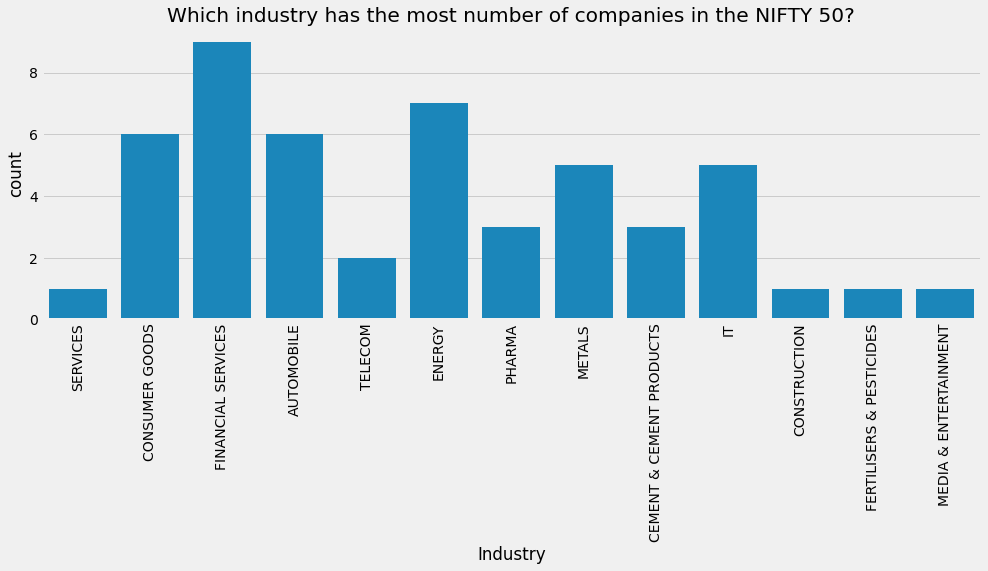

In [3]:
plt.figure(figsize=(15,5))
plt.title('Which industry has the most number of companies in the NIFTY 50?')
sns.countplot(x=meta.Industry,color=color_pal[0])
plt.xticks(rotation=90)
plt.show()

In [4]:
adani = pd.read_csv("dataset/ADANIPORTS.csv")
adani.head(5)

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2007-11-27,MUNDRAPORT,EQ,440.00,770.00,1050.00,770.0,959.0,962.90,984.72,27294366,2.687719e+15,NaN,9859619,0.3612
1,2007-11-28,MUNDRAPORT,EQ,962.90,984.00,990.00,874.0,885.0,893.90,941.38,4581338,4.312765e+14,NaN,1453278,0.3172
2,2007-11-29,MUNDRAPORT,EQ,893.90,909.00,914.75,841.0,887.0,884.20,888.09,5124121,4.550658e+14,NaN,1069678,0.2088
3,2007-11-30,MUNDRAPORT,EQ,884.20,890.00,958.00,890.0,929.0,921.55,929.17,4609762,4.283257e+14,NaN,1260913,0.2735
4,2007-12-03,MUNDRAPORT,EQ,921.55,939.75,995.00,922.0,980.0,969.30,965.65,2977470,2.875200e+14,NaN,816123,0.2741


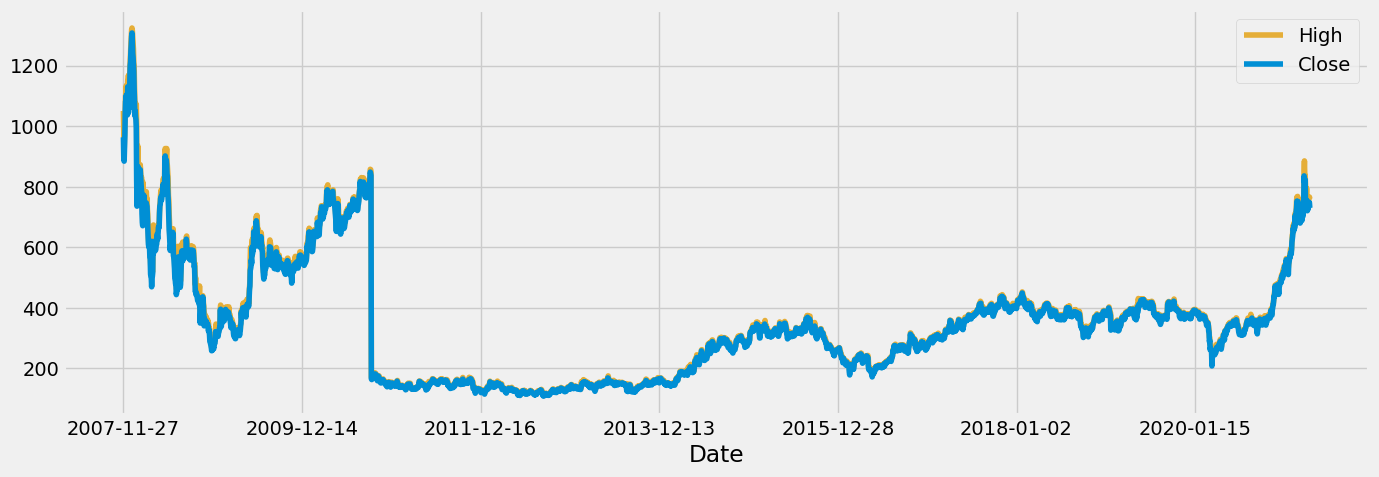

In [3]:
fig,ax = plt.subplots(figsize=(15,5))
adani.plot(ax=ax,x='Date',y='High',color=color_pal[2])
adani.plot(ax=ax,x='Date',y='Close',color=color_pal[0])
plt.show()

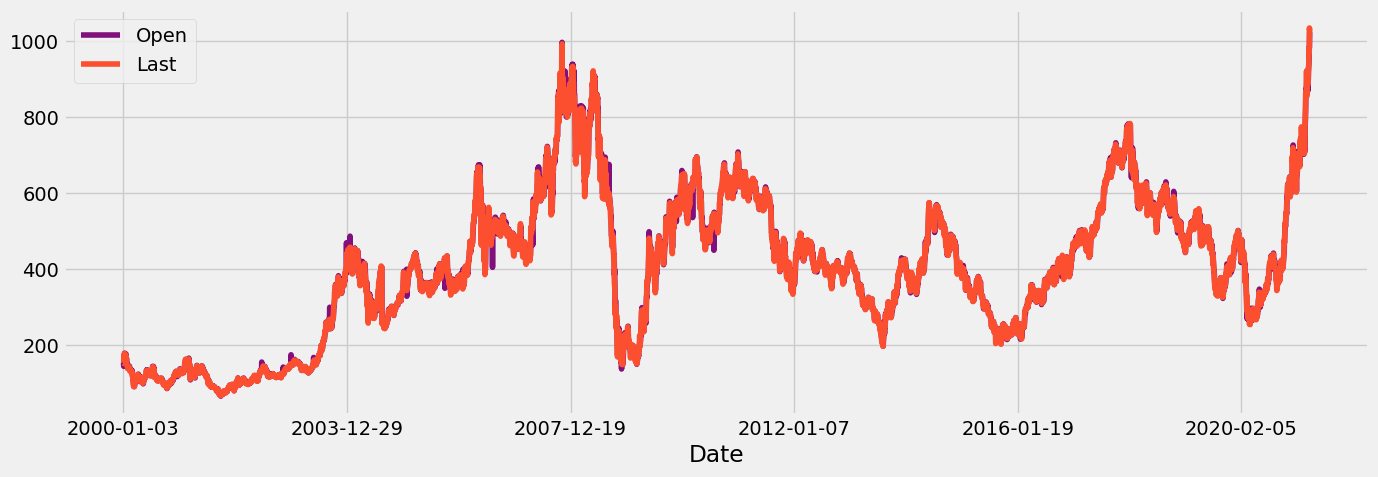

In [4]:
tatasteel = pd.read_csv("dataset/TATASTEEL.csv")
fig,ax = plt.subplots(figsize=(15,5))
tatasteel.plot(ax=ax,x='Date',y='Open',color=color_pal[5])
tatasteel.plot(ax=ax,x='Date',y='Last',color=color_pal[1])
plt.show()

In [5]:
tatasteel.tail()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
5301,2021-04-26,TATASTEEL,EQ,925.60,935.0,956.00,930.05,942.5,940.75,942.98,21234858,2.002407e+15,274958.0,4584617.0,0.2159
5302,2021-04-27,TATASTEEL,EQ,940.75,948.3,983.00,944.30,982.0,977.75,965.43,24904515,2.404346e+15,331493.0,3575969.0,0.1436
5303,2021-04-28,TATASTEEL,EQ,977.75,985.0,986.00,962.00,971.0,971.40,972.08,20447968,1.987700e+15,255599.0,3550908.0,0.1737
5304,2021-04-29,TATASTEEL,EQ,971.40,983.0,1036.95,983.00,1035.0,1031.35,1015.76,44718647,4.542359e+15,554647.0,5539528.0,0.1239
5305,2021-04-30,TATASTEEL,EQ,1031.35,1024.0,1052.60,1011.10,1025.6,1034.00,1031.95,28129738,2.902854e+15,385840.0,3536863.0,0.1257


# Manual Temporal Split

In [6]:
cutoff_date = '2020-06-01'
train = tatasteel.loc[tatasteel.Date<cutoff_date]
test = tatasteel.loc[tatasteel.Date>=cutoff_date]

In [7]:
def create_datetime_features(df,date):
    df['month'] = pd.to_datetime(df[date]).dt.month
    df['year'] = pd.to_datetime(df[date]).dt.year
    df['weekday'] = pd.to_datetime(df[date]).dt.dayofweek
    df['quarter'] = pd.to_datetime(df[date]).dt.quarter
    return df

In [8]:
train = create_datetime_features(train,'Date')
test = create_datetime_features(test,'Date')

C:\Users\prana\AppData\Local\Temp\ipykernel_5400\2002858062.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = pd.to_datetime(df[date]).dt.month
C:\Users\prana\AppData\Local\Temp\ipykernel_5400\2002858062.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = pd.to_datetime(df[date]).dt.year
C:\Users\prana\AppData\Local\Temp\ipykernel_5400\2002858062.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

As our target feature we would use the Open prices.

Let us start with XGBoost for modelling.

In [9]:
train.columns

Index(['Date', 'Symbol', 'Series', 'Prev Close', 'Open', 'High', 'Low', 'Last',
       'Close', 'VWAP', 'Volume', 'Turnover', 'Trades', 'Deliverable Volume',
       '%Deliverble', 'month', 'year', 'weekday', 'quarter'],
      dtype='object')

In [1]:
#Splitting the data into X and y

X_train = train[['Volume', 'Turnover', 'Trades', 'Deliverable Volume',
       '%Deliverble', 'month', 'year', 'weekday']]
y_train = train.Open
X_test = test[['Volume', 'Turnover', 'Trades', 'Deliverable Volume',
       '%Deliverble', 'month', 'year', 'weekday']]
y_test = test.Open

NameError: name 'train' is not defined

In [11]:
#Reference: https://www.kaggle.com/code/robikscube/time-series-forecasting-with-machine-learning-yt#Forecast-on-Test
model = XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)

In [12]:
model.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test,y_test)],verbose=100)

: 

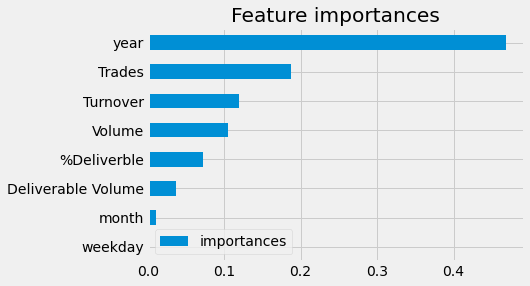

In [15]:
imp = pd.DataFrame(model.feature_importances_,index=model.feature_names_in_,columns=['importances'])
imp.sort_values('importances').plot(kind='barh',title='Feature importances')
plt.show()

In [16]:
X_test['preds'] = model.predict(X_test)
tatasteel = tatasteel.merge(X_test[['preds']], how='left', left_index=True, right_index=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


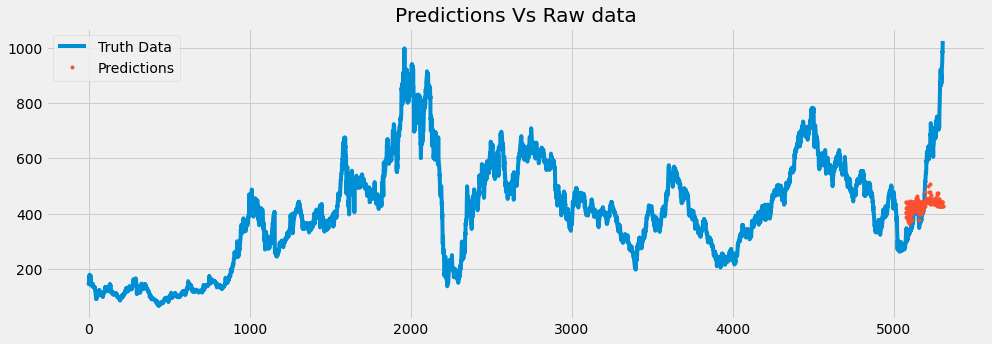

In [17]:
ax = tatasteel[['Open']].plot(figsize=(15,5))
tatasteel.preds.plot(style='.',ax=ax,title='Predictions Vs Raw data')
plt.legend(['Truth Data', 'Predictions'])
plt.show()

The current XGB model seems to be doing a pretty bad job on the predictions. We would need to make this better.

# Sklearn's Cross Validation for train test split

In [18]:
#Reference: https://www.kaggle.com/code/robikscube/pt2-time-series-forecasting-with-xgboost/notebook
from sklearn.model_selection import TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=5,test_size=180,gap=2)
tatasteel = tatasteel.sort_index()

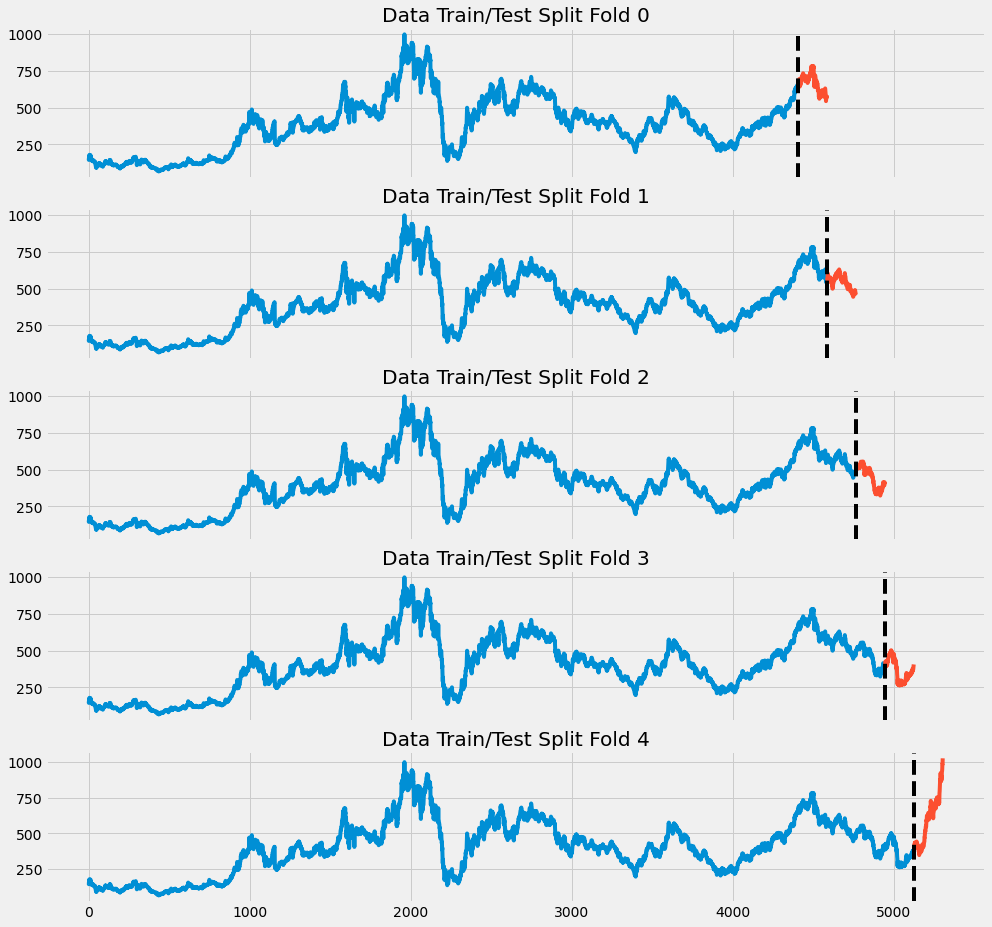

In [19]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)
fold = 0
for train_idx , val_idx in tss.split(tatasteel):
    train = tatasteel.iloc[train_idx]
    test = tatasteel.iloc[val_idx]
    train['Open'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['Open'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [20]:
fold = 0
preds = []
scores = []
for train_idx , val_idx in tss.split(tatasteel):
    train = tatasteel.iloc[train_idx]
    test = tatasteel.iloc[val_idx]
    
    train = create_datetime_features(train,'Date')
    test = create_datetime_features(test,'Date')
    
    FEATURES = ['Volume', 'Turnover', 'Trades', 'Deliverable Volume',
       '%Deliverble', 'month', 'year', 'weekday','quarter']
    TARGET = ['Open']
    
    X_train = train[FEATURES]
    y_train = train[TARGET]
    
    X_test = test[FEATURES]
    y_test = test[TARGET]
    
    reg = XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[11:09:12] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:418.50488	validation_1-rmse:665.13583


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

[100]	validation_0-rmse:176.91492	validation_1-rmse:354.00347
[200]	validation_0-rmse:95.13275	validation_1-rmse:225.97901
[300]	validation_0-rmse:65.26604	validation_1-rmse:158.79350
[400]	validation_0-rmse:52.99238	validation_1-rmse:125.27976
[500]	validation_0-rmse:45.02570	validation_1-rmse:105.77894
[600]	validation_0-rmse:39.76048	validation_1-rmse:93.92940
[700]	validation_0-rmse:35.81887	validation_1-rmse:84.98534
[800]	validation_0-rmse:32.87651	validation_1-rmse:78.91588
[900]	validation_0-rmse:30.55131	validation_1-rmse:74.38848
[999]	validation_0-rmse:28.70893	validation_1-rmse:69.79083
[11:09:20] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:430.82703	validation_1-rmse:541.74365


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

[100]	validation_0-rmse:180.35545	validation_1-rmse:203.41711
[200]	validation_0-rmse:94.60920	validation_1-rmse:82.86177
[300]	validation_0-rmse:66.20740	validation_1-rmse:45.16534
[400]	validation_0-rmse:52.95428	validation_1-rmse:41.64388
[437]	validation_0-rmse:49.55827	validation_1-rmse:42.72879
[11:09:23] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:435.56073	validation_1-rmse:448.12112


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

[100]	validation_0-rmse:181.48262	validation_1-rmse:127.60562
[200]	validation_0-rmse:94.56608	validation_1-rmse:72.61918
[248]	validation_0-rmse:76.74208	validation_1-rmse:76.08164
[11:09:25] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:436.06887	validation_1-rmse:367.84935


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

[100]	validation_0-rmse:182.05316	validation_1-rmse:84.63199
[182]	validation_0-rmse:105.06552	validation_1-rmse:83.55019
[11:09:27] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:433.90522	validation_1-rmse:611.04244


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

[100]	validation_0-rmse:182.68086	validation_1-rmse:328.84830
[200]	validation_0-rmse:98.24943	validation_1-rmse:250.09253
[300]	validation_0-rmse:68.88839	validation_1-rmse:240.90493
[400]	validation_0-rmse:54.67670	validation_1-rmse:238.73145
[449]	validation_0-rmse:50.10593	validation_1-rmse:239.50909


In [21]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 98.9334
Fold scores:[69.79082599401335, 41.432454647514156, 72.55368117257818, 72.2320895617184, 238.6578372920843]


With the time series split we were able to reduce the average score across folds to 98.


Thanks to Rohan's [notebook](http://www.kaggle.com/code/rohanrao/a-modern-time-series-tutorial/notebook) I realised that using tree based models like LightGBM in a time series that has a strong trend component is not a good idea, simply because tree based models can only predict values which are lower than the upper bound they have seen in the training data.

If the training data has a maximum value of 1500 rupees then the tree based model would not be able to predict a value greater than 1500. 

We would try to use lag features and use Facebook's Prophet model for predictions and we would now be predicting the VWAP feature.

In [22]:
tatasteel.columns

Index(['Date', 'Symbol', 'Series', 'Prev Close', 'Open', 'High', 'Low', 'Last',
       'Close', 'VWAP', 'Volume', 'Turnover', 'Trades', 'Deliverable Volume',
       '%Deliverble', 'preds'],
      dtype='object')

In [23]:
tatasteel.reset_index(drop=True, inplace=True)
lag_features = ["High", "Low", "Volume", "Turnover", "Trades"]
window1 = 3
window2 = 7
window3 = 30

tatasteel_rolled_3d = tatasteel[lag_features].rolling(window=window1, min_periods=0)
tatasteel_rolled_7d = tatasteel[lag_features].rolling(window=window2, min_periods=0)
tatasteel_rolled_30d = tatasteel[lag_features].rolling(window=window3, min_periods=0)

tatasteel_mean_3d = tatasteel_rolled_3d.mean().shift(1).reset_index().astype(np.float32)
tatasteel_mean_7d = tatasteel_rolled_7d.mean().shift(1).reset_index().astype(np.float32)
tatasteel_mean_30d = tatasteel_rolled_30d.mean().shift(1).reset_index().astype(np.float32)

tatasteel_std_3d = tatasteel_rolled_3d.std().shift(1).reset_index().astype(np.float32)
tatasteel_std_7d = tatasteel_rolled_7d.std().shift(1).reset_index().astype(np.float32)
tatasteel_std_30d = tatasteel_rolled_30d.std().shift(1).reset_index().astype(np.float32)

for feature in lag_features:
    tatasteel[f"{feature}_mean_lag{window1}"] = tatasteel_mean_3d[feature]
    tatasteel[f"{feature}_mean_lag{window2}"] = tatasteel_mean_7d[feature]
    tatasteel[f"{feature}_mean_lag{window3}"] = tatasteel_mean_30d[feature]
    
    tatasteel[f"{feature}_std_lag{window1}"] = tatasteel_std_3d[feature]
    tatasteel[f"{feature}_std_lag{window2}"] = tatasteel_std_7d[feature]
    tatasteel[f"{feature}_std_lag{window3}"] = tatasteel_std_30d[feature]

tatasteel.fillna(tatasteel.mean(), inplace=True)

tatasteel.set_index("Date", drop=False, inplace=True)
tatasteel.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,...,Turnover_mean_lag30,Turnover_std_lag3,Turnover_std_lag7,Turnover_std_lag30,Trades_mean_lag3,Trades_mean_lag7,Trades_mean_lag30,Trades_std_lag3,Trades_std_lag7,Trades_std_lag30
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,2000-01-03,TISCO,EQ,142.35,148.00,153.2,146.10,152.50,152.45,150.92,...,2.596786e+14,7.498199e+13,9.013064e+13,1.069192e+14,93700.914062,93488.023438,92326.554688,24493.755859,29187.878906,33776.886719
2000-01-04,2000-01-04,TISCO,EQ,152.45,150.10,153.0,143.05,151.95,150.80,151.03,...,3.023164e+13,7.498199e+13,9.013064e+13,1.069192e+14,93700.914062,93488.023438,92326.554688,24493.755859,29187.878906,33776.886719
2000-01-05,2000-01-05,TISCO,EQ,150.80,144.60,162.9,144.60,158.00,156.55,156.85,...,2.685975e+13,4.768579e+12,4.768579e+12,4.768579e+12,93700.914062,93488.023438,92326.554688,24493.755859,29187.878906,33776.886719
2000-01-06,2000-01-06,TISCO,EQ,156.55,158.95,169.1,158.95,169.00,168.25,167.61,...,3.798438e+13,1.956124e+13,1.956124e+13,1.956124e+13,93700.914062,93488.023438,92326.554688,24493.755859,29187.878906,33776.886719
2000-01-07,2000-01-07,TISCO,EQ,168.25,173.40,179.0,166.30,170.55,171.95,173.89,...,3.921711e+13,1.838298e+13,1.616085e+13,1.616085e+13,93700.914062,93488.023438,92326.554688,24493.755859,29187.878906,33776.886719


In [24]:
tatasteel = create_datetime_features(tatasteel,'Date')

In [25]:
tatasteel.columns

Index(['Date', 'Symbol', 'Series', 'Prev Close', 'Open', 'High', 'Low', 'Last',
       'Close', 'VWAP', 'Volume', 'Turnover', 'Trades', 'Deliverable Volume',
       '%Deliverble', 'preds', 'High_mean_lag3', 'High_mean_lag7',
       'High_mean_lag30', 'High_std_lag3', 'High_std_lag7', 'High_std_lag30',
       'Low_mean_lag3', 'Low_mean_lag7', 'Low_mean_lag30', 'Low_std_lag3',
       'Low_std_lag7', 'Low_std_lag30', 'Volume_mean_lag3', 'Volume_mean_lag7',
       'Volume_mean_lag30', 'Volume_std_lag3', 'Volume_std_lag7',
       'Volume_std_lag30', 'Turnover_mean_lag3', 'Turnover_mean_lag7',
       'Turnover_mean_lag30', 'Turnover_std_lag3', 'Turnover_std_lag7',
       'Turnover_std_lag30', 'Trades_mean_lag3', 'Trades_mean_lag7',
       'Trades_mean_lag30', 'Trades_std_lag3', 'Trades_std_lag7',
       'Trades_std_lag30', 'month', 'year', 'weekday', 'quarter'],
      dtype='object')

In [26]:
df_train = tatasteel[tatasteel.Date < "2019"]
df_valid = tatasteel[tatasteel.Date >= "2019"]

exogenous_features = ["High_mean_lag3", "High_std_lag3", "Low_mean_lag3", "Low_std_lag3",
                      "Volume_mean_lag3", "Volume_std_lag3", "Turnover_mean_lag3",
                      "Turnover_std_lag3", "Trades_mean_lag3", "Trades_std_lag3",
                      "High_mean_lag7", "High_std_lag7", "Low_mean_lag7", "Low_std_lag7",
                      "Volume_mean_lag7", "Volume_std_lag7", "Turnover_mean_lag7",
                      "Turnover_std_lag7", "Trades_mean_lag7", "Trades_std_lag7",
                      "High_mean_lag30", "High_std_lag30", "Low_mean_lag30", "Low_std_lag30",
                      "Volume_mean_lag30", "Volume_std_lag30", "Turnover_mean_lag30",
                      "Turnover_std_lag30", "Trades_mean_lag30", "Trades_std_lag30",
                      'month', 'year', 'weekday', 'quarter']

In [27]:
!pip install pystan
!pip install prophet
from prophet import Prophet
model_fbp = Prophet()
for feature in exogenous_features:
    model_fbp.add_regressor(feature)

model_fbp.fit(df_train[["Date", "VWAP"] + exogenous_features].rename(columns={"Date": "ds", "VWAP": "y"}))

forecast = model_fbp.predict(df_valid[["Date", "VWAP"] + exogenous_features].rename(columns={"Date": "ds"}))
df_valid["Forecast_Prophet"] = forecast.yhat.values

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 695.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 MB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 65.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 4.8 MB/s eta 0:00:00


11:10:09 - cmdstanpy - INFO - Chain [1] start processing
11:10:15 - cmdstanpy - INFO - Chain [1] done processing
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


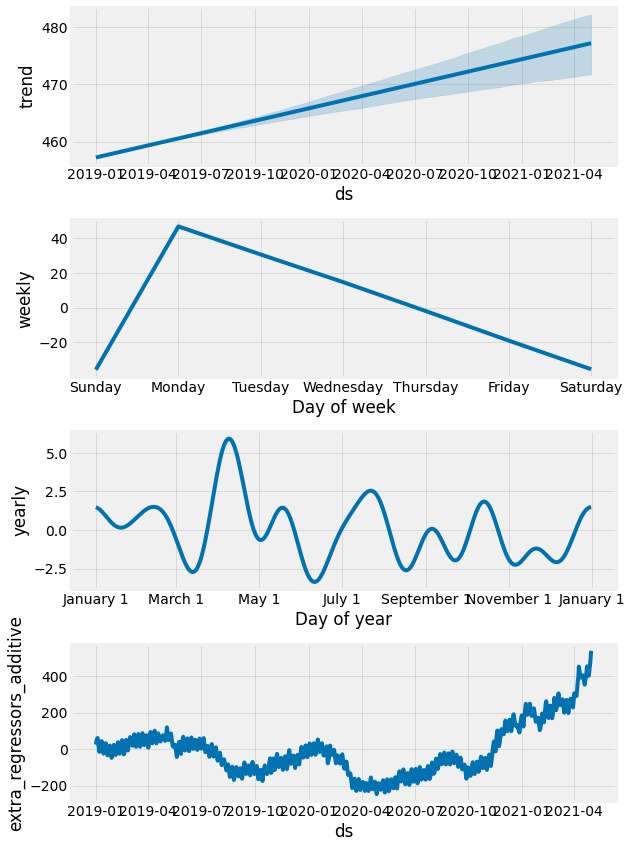

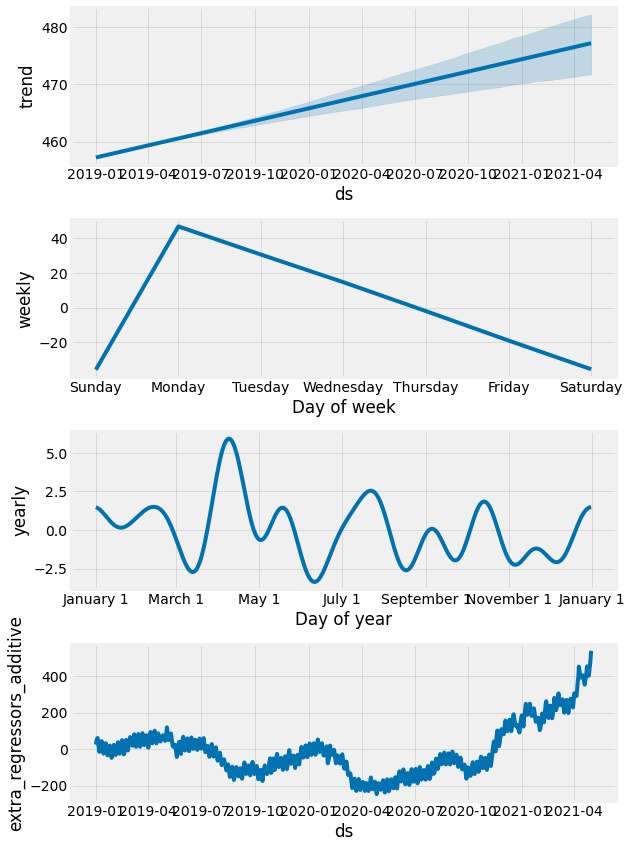

In [28]:
model_fbp.plot_components(forecast)

<AxesSubplot:xlabel='Date'>

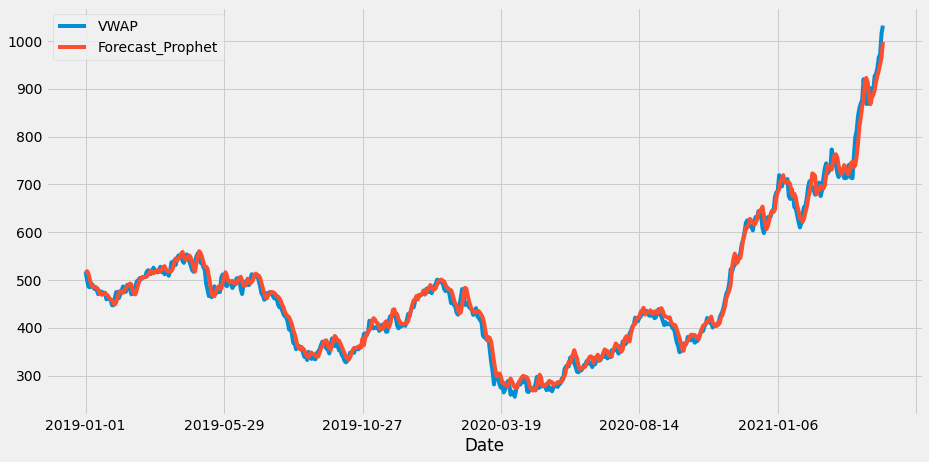

In [29]:
df_valid[["VWAP","Forecast_Prophet"]].plot(figsize=(14, 7))

Voila! Prophet was able to forecast the predictions really well.


In [30]:
from sklearn.metrics import mean_absolute_error

In [31]:
print("RMSE of Prophet:", np.sqrt(mean_squared_error(df_valid.VWAP, df_valid.Forecast_Prophet)))
print("MAE of Prophet:", mean_absolute_error(df_valid.VWAP, df_valid.Forecast_Prophet))

RMSE of Prophet: 15.457583794928754
MAE of Prophet: 11.693150536140921
